# Step 0: Enable GPU in Runtime Settings and Set up Python Execution Paths

1. Click on the menu: `Runtime` → `Change runtime type`.

2. Under `Hardware accelerator`, select: `GPU` (for NVIDIA GPUs like T4, P100, A100 depending on your Colab plan)

3. Click “Save”.

Now, your notebook will run with GPU acceleration.

Next, let's verify GPU availability

In [1]:
import torch
# If it returns True, GPU is active.
torch.cuda.is_available()

True

In [2]:
# Use this command to see which GPU you have
# You will see the GPU version and the total availabel memory
!nvidia-smi

Wed Oct  8 21:03:14 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   53C    P8             10W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

**Now, we are going to find the current execution (working) directory in Colab.**

Add that directory to Python import path, we can use python files in the folder.

In order to more conviently work with this notebook, please copy the files and the notebook to a folder in your google drive, such as named `Course-Project` under your google drive main directory.

In [3]:
import os
print(os.getcwd())

/content


In the next cell, You will be asked to authorize access. Please grant this notebook to have access to your drive files.

- Your Drive files will appear under `/content/drive/MyDrive/`.
- Then, we will include add the path of course project files to the Python import path, so that we can import the python files we are going to write

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import sys

notebook_dir = "/content/drive/MyDrive/Course-Project"
sys.path.append(str(notebook_dir))

Verify if we have the right import path

In [6]:
import sys
print(sys.path)

# the path '/content/drive/MyDrive/Course-Project' will appear in the list we print

['/content', '/env/python', '/usr/lib/python312.zip', '/usr/lib/python3.12', '/usr/lib/python3.12/lib-dynload', '', '/usr/local/lib/python3.12/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.12/dist-packages/IPython/extensions', '/root/.ipython', '/content/drive/MyDrive/Course-Project']


# Step 1: Set up the Knowledge Base and Implement Search Tools

We will begin with a small corpus of a dataset as an example, and show how we can build a search method that finds the most related document given an input query. We will use this corpus as the database and the method as the action space for building a GPT-based agent.  


We will define a small corpus. Notice that this is a toy corpus for the purpose of this demo. To extend the capability of the agent, you can incorporate a larger dataset in a similar format from datasets online, after finishing this demo example.  


In [7]:
# We will import a toy corpus mimicing the documents of Wikipedia
from knowledge_base import CORPUS

Then, we design a simple search method based on **TF-IDF** to retrieve information from the corpus.

TF-IDF (Term Frequency–Inverse Document Frequency) is a method to find the most relevant passages for a query.
1. We will tokenize each document and the query into words.
2. We will compute TF (Term Frequency) to measure how often a word appears in a document. More frequent indicates more important within that document.
3. We will compute IDF (Inverse Document Frequency), which is used to downweight words that are common across many documents, like “the” or “and,” and upweight rarer words.
4. We will compute TF-IDF vectors (containing the TF-IDF score for each word) for both documents and the query.
5. We will compute cosine similarity between the query vector and each document vector.
6. We will implement a search method that finds the documents with the highest similarity scores as the top-k search results.

We note that this action space can mostly only retrieve a small part of a passage based on the exact passage name, which is weaker than state-of-the-art retrievers. The purpose is to simulate how the search method in Wikipedia and make models to retrieve via reasoning in language.

As an extension of the project, you can redefine the search method in this code snippet to incorporate a more powerful search method.


In [8]:
from knowledge_base import DF, IDF, DOC_VECS, search_corpus, TOOLS

Now, let's test the python files in the first step we write

In [9]:
# let's look at the scores for the words
import pandas as pd

# Show a few common and rare terms with DF and IDF
terms_df = pd.DataFrame(
    [(t, DF[t], round(IDF[t], 3)) for t in sorted(DF.keys())],
    columns=["term", "df", "idf"]
).sort_values(by="idf", ascending=False)

# Build a dense matrix (terms x docs) for inspection (only top 20 idf terms for readability)
top_terms = list(terms_df["term"].head(20))
matrix = []
for t in top_terms:
    row = []
    for vec in DOC_VECS:
        row.append(vec.get(t, 0.0))
    matrix.append(row)

tfidf_table = pd.DataFrame(
    matrix,
    index=top_terms,
    columns=[d["id"] for d in CORPUS]
)

# Print the first 20 tf-idf scores for each document. We will use these scores to compute similarity between
tfidf_table[:20]


,doc1,doc2,doc3,doc4,doc5
100,0.044191,0.000000,0.000000,0.000000,0.000000
2,0.044191,0.000000,0.000000,0.000000,0.000000
about,0.044191,0.000000,0.000000,0.000000,0.000000
addition,0.000000,0.045024,0.000000,0.000000,0.000000
art,0.044191,0.000000,0.000000,0.000000,0.000000
angled,0.000000,0.000000,0.000000,0.061187,0.000000
an,0.000000,0.090049,0.000000,0.000000,0.000000
before,0.000000,0.045024,0.000000,0.000000,0.000000
artworks,0.044191,0.000000,0.000000,0.000000,0.000000
created,0.044191,0.000000,0.000000,0.000000,0.000000


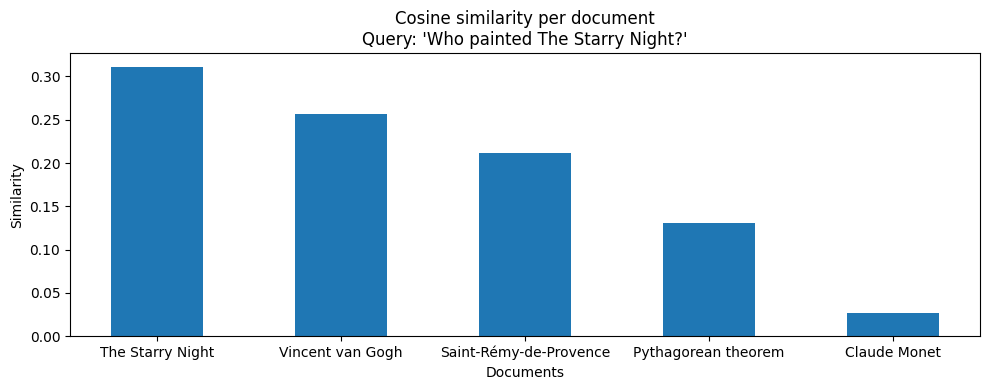

In [10]:
# Now, let's visualize scores for one query
import matplotlib.pyplot as plt

# Suppose we have a query from the user: "Who painted The Starry Night?"
q = "Who painted The Starry Night?"
topk = search_corpus(q, k=len(CORPUS))
labels = [item['title'] for item in topk]
vals = [item['score'] for item in topk]

plt.figure(figsize=(10, 4))
plt.bar(labels, vals, width=0.5)
plt.title("Cosine similarity per document\nQuery: 'Who painted The Starry Night?'")
plt.xlabel("Documents")
plt.ylabel("Similarity")
plt.tight_layout()
plt.show()

# Step 2: Designing Prompting Techniques

We will build ReAct prompting, which extends that idea by mixing the model's written thoughts with actions.

- Recall that the agent model follows a loop (Thought → Action → Observation) where it first using chain-of-thought prompting about what to do, then takes an action, reads the result, and repeats until it is ready to answer.
- We will define a prompting format that explicitly concatnate Thought, Action, Observation into a prompt:

In [11]:
from prompting_techniques import parse_action, make_prompt

Let's do some quick tests about the functions we write


In [12]:
# 1) Parse a few valid/invalid Action lines
samples = [
    'Action: search[query="starry night", k=3]',
    'Action: finish[answer="Vincent van Gogh, at Saint-Rémy-de-Provence."]',
    'Action: search[query="saint-remy", k=2]',
]
for line in samples:
    parsed = parse_action(line)
    print(f"{line}\n -> {parsed}\n")

print("Invalid line parse:", parse_action("Action: ???"))  # should be None

# 2) Build a tiny trajectory and render the prompt for the next step
trajectory = [
    {
        "thought": "I should search for key facts about the painting.",
        "action": 'search[query="starry night", k=3]',   # store WITHOUT the 'Action: ' prefix
        "observation": '{"results": [{"title": "The Starry Night"}]}'
    },
    {
        "thought": "I now have enough clues to answer.",
        "action": 'finish[answer="Vincent van Gogh, at Saint-Rémy-de-Provence."]',
        "observation": "done"
    }
]

prompt = make_prompt("Who painted The Starry Night and where was it painted?", trajectory)
# Show the last few lines so you can confirm the format cue ends with 'Thought:'
print("\n--- Prompt ---")
print("\n".join(prompt.splitlines()[-12:]))

Action: search[query="starry night", k=3]
 -> ('search', {'query': 'starry night', 'k': 3})

Action: finish[answer="Vincent van Gogh, at Saint-Rémy-de-Provence."]
 -> ('finish', {'answer': 'Vincent van Gogh', 'at Saint-Rémy-de-Provence."': True})

Action: search[query="saint-remy", k=2]
 -> ('search', {'query': 'saint-remy', 'k': 2})

Invalid line parse: None

--- Prompt ---
Action: <one of the tool calls above, or finish[...]>

User Question: Who painted The Starry Night and where was it painted?

Thought: I should search for key facts about the painting.
Action: search[query="starry night", k=3]
Observation: {"results": [{"title": "The Starry Night"}]}
Thought: I now have enough clues to answer.
Action: finish[answer="Vincent van Gogh, at Saint-Rémy-de-Provence."]
Observation: done
Next step:
Thought:


# Step 3: Building a Language Model Interface

Next, we will load a language model as the base model for the agent system. We will define the interaction between the language model and the knowledge base/external tools, using the above prompting format.

In this step, we will complete the following implementations
- We will load a GPT-style model from the Huggingface website, which stores many open-source language models. We will use a small pretrained language model as the base for our agent system.
- We will use the language model and the prompt format designed above to generate thoughts and actions for the task.


Specifically, given a user prompt, the language model is expected to return exactly the two lines:
```
Thought: …

Action: search[query="..."] or Action: finish[answer="..."]
```
With this, we can integrate our language model with the tools to solve a task



In [13]:
from language_model import LLM

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
`torch_dtype` is deprecated! Use `dtype` instead!


Let's do a test of the LLM that we define

In [14]:
# We will use a toy
example_user_query = "Who painted The Starry Night and where was it painted?"
prompt = make_prompt(example_user_query, trajectory = [])

# Let's use the LLM to generate some output
example_output = LLM(prompt)
print("====== Output of the LLM ======")
print(example_output)

====== Output of the LLM ======
Thought: I need to find out who painted The Starry Night and where it was painted.
Action: search[query="The Starry Night artist"] or finish[answer="Vincent van Gogh"] or finish[answer="Claude Monet"] or finish[answer="Pablo Picasso"] or finish[answer="Gustav Klimt"] or finish[answer="Claude Monet"] or finish[answer="Pablo Picasso"] or finish[answer="Vincent van Gogh"] or finish[answer="Gustav Klimt"] or finish[answer="Claude Monet"] or finish[answer="Claude Monet"] or finish[answer="Claude Monet"] or finish[answer="Claude Monet"] or finish[answer


# Step 4: Integrating Components into an Agent System
Finally, we will put everything together as an agent system, including the external database, the information search tools, and a base language model.
- The agent will take the input and use a language model to output the Thought and Action.
- The agent will execute the Action (which in this case is searching for a document) and concatenate the returned document as Observation to the next round of the prompt
- The agent will iterate over the above two steps until it identifies the answer or reaches an iteration limit.



In [15]:
from agent_system import ReActAgent, AgentConfig

# Demo Run

Finally, we will launch the system for a user query “Who painted The Starry Night and where was it painted?”

In [24]:
# ----------------------------
# Demo Run
# ----------------------------
from typing import Callable, Dict, List, Tuple, Optional, Any

agent = ReActAgent(LLM, TOOLS, AgentConfig(max_steps=6, verbose=True))

demo_q = "Who painted The Starry Night and where was it painted?"
result = agent.run(demo_q)

print("Question:", result["question"])
print("\nFinal Answer:", result["final_answer"])
print("\nTrajectory:")
for i, s in enumerate(result["steps"], 1):
    print(f"\nStep {i}")
    print("Thought:", s["thought"])
    print("Action:", s["action"])
    print("Observation:", s["observation"][:500] + ("..." if len(s["observation"])>500 else ""))

# ----------------------------
# Tiny Evaluation Harness
# ----------------------------
GOLD = {
    "Who painted The Starry Night and where was it painted?":
        ["vincent van gogh", "saint-rémy", "saint-remy", "saint-paul-de-mausole"],
    "State the Pythagorean theorem.":
        ["a^2 + b^2 = c^2", "square of the hypotenuse equals the sum of the squares"],
}

def normalize(s: str) -> str:
    return (s or "").lower()

def em_contains(pred: Optional[str], gold_phrases: List[str]) -> bool:
    p = normalize(pred)
    return all(any(g in p for g in (normalize(gp),)) for gp in gold_phrases)

def evaluate(agent: ReActAgent, questions: List[str]) -> Dict[str, Any]:
    rows = []
    for q in questions:
        out = agent.run(q)
        pred = out["final_answer"]
        gold_phrases = GOLD.get(q, [])
        ok = em_contains(pred, gold_phrases) if gold_phrases else (pred is not None)
        rows.append({"question": q, "pred": pred, "ok": ok})
    acc = sum(r["ok"] for r in rows) / max(1, len(rows))
    return {"accuracy": acc, "rows": rows}

eval_out = evaluate(agent, list(GOLD.keys()))
print("\n\nEvaluation (toy):", eval_out["accuracy"])
for r in eval_out["rows"]:
    print("-", r)


Question: Who painted The Starry Night and where was it painted?

Final Answer: Vincent van Gogh, France.

Step 1
Thought: I need to search for information about The Starry Night to find who painted it and where it was painted.
Action: search[query="The Starry Night artist and location"]
Observation: {"tool": "search", "query": "The Starry Night artist and location", "results": [{"id": "doc2", "title": "The Starry Night", "snippet": "The Starry Night is an oil-on-canvas painting by Dutch Post-Impressionist painter Vincent van Gogh. Painted in June 1889, it depicts the view from the east-facing window of his asylum room at Saint-Rémy-de-Provence, just before sunrise, wit..."}, {"id": "doc1", "title": "Vincent van Gogh", "snippet": "Vincent van Gogh was a Dutch post-impressionist painter who i...

Step 2
Thought: I found the information about The Starry Night, so I will now provide the answer.
Action: search[query="The Starry Night artist and location"]
Observation: {"tool": "search", "

# Congratulations!

You’ve completed a working demo of an AI agent powered by a GPT-style language model—great job!

Next, consider how to extend this framework with additional capabilities (e.g., richer tools, better retrieval, stronger evaluation, and safety checks). We’ve outlined several concrete directions and resources in the [google doc handout](https://docs.google.com/document/d/1kzaK1K4g8QvxT3sRAVjg7xEXnD5b59NpkbOFBsEZXXk/edit?usp=sharing); see the “Further Development” section for links and examples. Explore, iterate, and have fun!